Not all the data exploration methods listed in https://github.com/hanhanwu/Hanhan_Applied_DataScience#data-exploration are mentioned here. Only some methods used less frequently but still useful.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2, f_classif
from matplotlib import pylab as plt
import math

In [2]:
sample_data = pd.read_csv('Big_Mart_Train_preprocessed.csv')
print(sample_data.shape)
sample_data.head()

(8523, 11)


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,0,0.016047,4,249.8092,9,18,1,0,1,3735.1380
1,5.92,1,0.019278,14,48.2692,3,8,1,2,2,443.4228
2,17.50,0,0.016760,10,141.6180,9,18,1,0,1,2097.2700
3,19.20,1,0.000000,6,182.0950,0,19,1,2,0,732.3800
4,8.93,0,0.000000,9,53.8614,1,30,0,2,1,994.7052


## Chi2 - Calculate the dependency between categorical values

* In sklearn, the variables all have to be numerical format, even object type won't be recognized
* In this case y is Outlet_Type, supposed to be categorical value. It calculates the dependency between y and features (some are categorical, others are numerical). <b>Higher chi2 score or lower p-values indicates there is higher dependecy between a feature and y</b>. Higher dependency with y means this feature is more important to the prediction.

In [16]:
chi2(sample_data, sample_data['Outlet_Type'])

(array([  4.38748776e+00,   6.41820613e-02,   2.81990046e+01,
          3.36657281e-01,   1.81798738e+01,   3.07607360e+03,
          1.68679106e+04,   1.39306214e+02,   1.71583962e+03,
          4.50034655e+03,   2.72572950e+06]),
 array([  2.22548371e-01,   9.95757787e-01,   3.29894838e-06,
          9.52993031e-01,   4.03829426e-04,   0.00000000e+00,
          0.00000000e+00,   5.33396205e-30,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]))

## ANOVA - Calculate the dependency between categorical and numerical values

* In sklearn, the variables all have to be numerical format, even object type won't be recognized
* It calculates the dependency between y and features (some are categorical, others are numerical). <b>Higher f-score score or lower p-values indicates there is higher dependecy between a feature and y</b>. Higher dependency with y means this feature is more important to the prediction.
* If the 2 variables are exactly the same, f-score will be inf and pvalue will be 0, indicating fully dependent
* Item_MRP has very higher feature importance when predicting Item_Outlet_Sales when I was using other algorithms such as xgboost. With ANOVA, it also has lowest p-value which means it has high dependency with the label.

In [18]:
f_classif(sample_data, sample_data['Item_Outlet_Sales'])

(array([ 1.04360971,  1.15475717,  1.21026743,  1.19135191,  3.44760491,
         1.20850702,  1.2300028 ,  1.00755482,  1.03294616,  2.17154746,
                inf]),
 array([  8.47509480e-002,   1.75123044e-006,   3.66664181e-010,
          8.09276729e-009,   0.00000000e+000,   4.93293944e-010,
          1.17094495e-011,   4.03797756e-001,   1.48381128e-001,
          4.34813733e-140,   0.00000000e+000]))

## Scatter Plot to show relationship between features and the label

* As we can see below, before and after data normalization, the overall shape of the relationship won't change much.
* Exactly linear relationship can be very difficult to find in real world data, so if the relationship is showing linear trend (such as Item_MRP vs Item_Outlet_Sales), is already good enough.
  * Also another assumption generated here, if the feature has linear relationship with the label, it may has higher feature importance ranking than those features have non-linear relationship with the label, even when the algorithm is nonparametric.

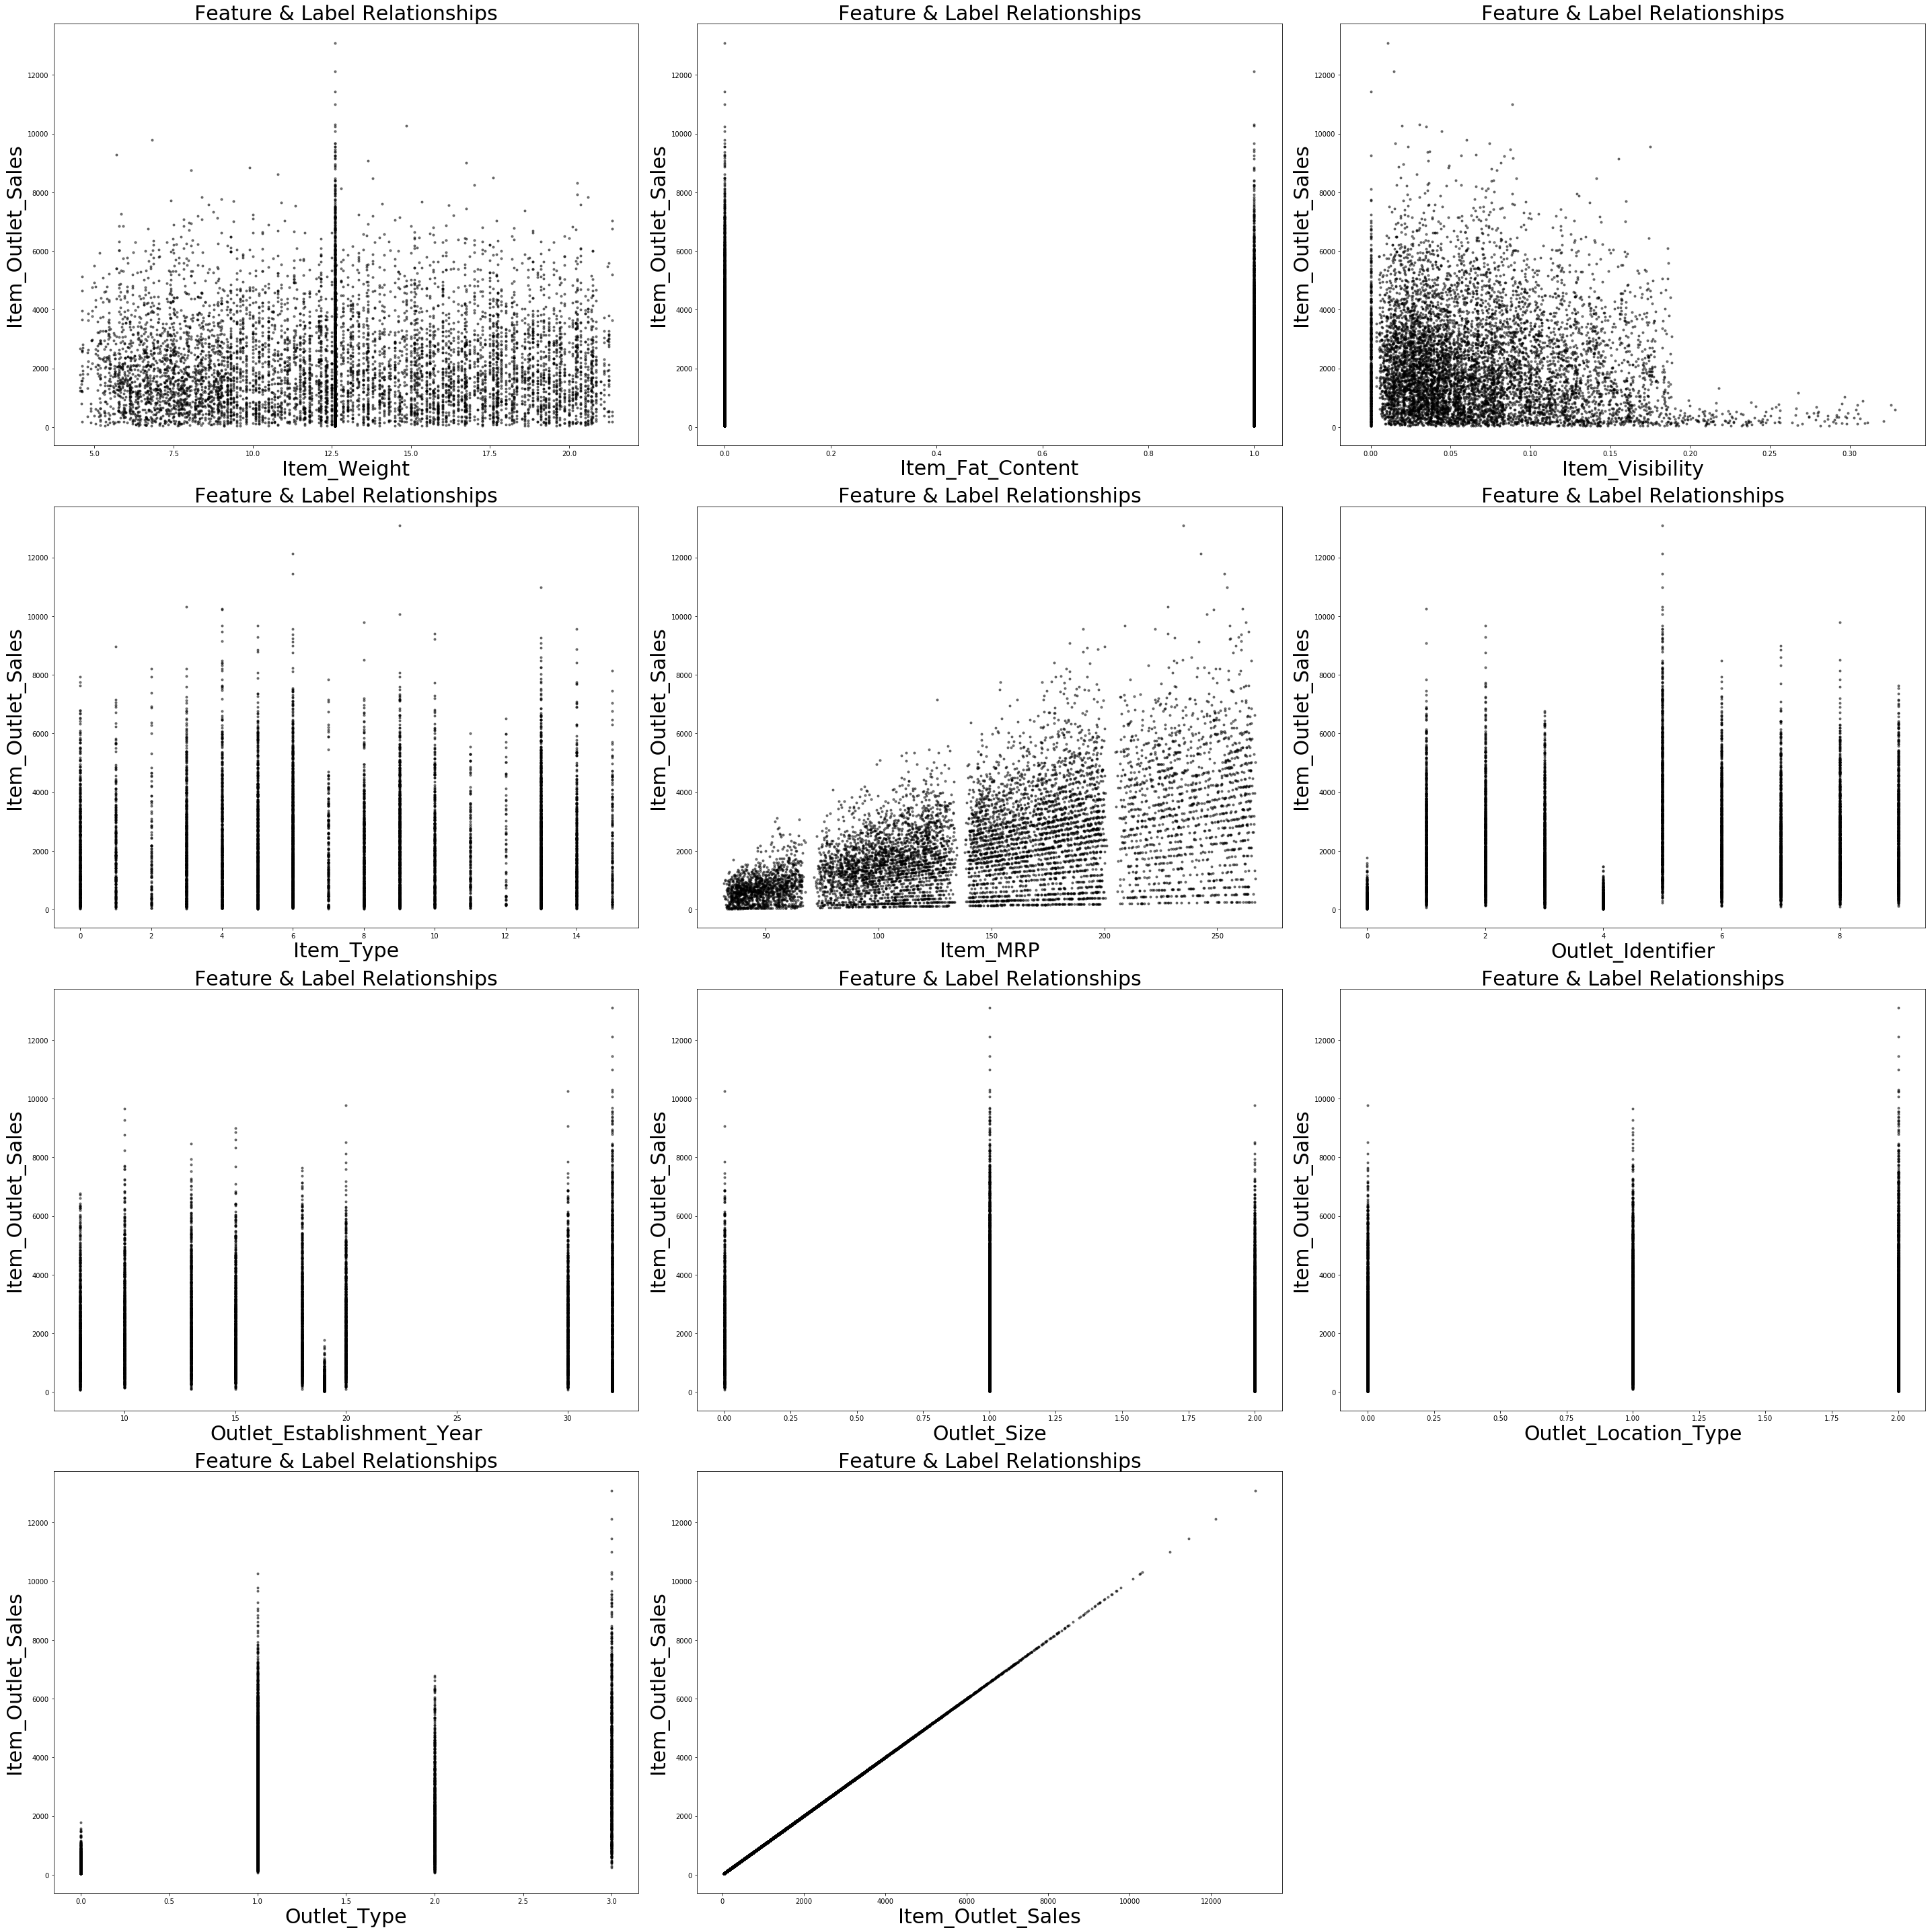

In [6]:
n_rows = 4
n_cols = 3
y = 'Item_Outlet_Sales'
area = np.pi*3
colors = (0,0,0)

def multi_scatter_plot(n_rows, n_cols, sample_data, y):
    i = 0
    fig=plt.figure(figsize=(40,40))
    for feature in sample_data.columns:
        i += 1
        ax=fig.add_subplot(n_rows,n_cols,i)

        plt.scatter(sample_data[feature], sample_data[y], s=area, c=colors, alpha=0.5)
        plt.title('Feature & Label Relationships', fontsize=30)
        plt.xlabel(feature, fontsize=30)
        plt.ylabel(y, fontsize=30)
    fig.tight_layout()
    plt.show()
    
multi_scatter_plot(n_rows, n_cols, sample_data, y)

## Residual Plot to show Linear/Nonlinear Relationship

* Seaborn method - The residual plot from seaborn requires x and y share the same shape. Therefore cannot be used for multiple dimensional feature set.

* Yellowbrick method - This is a better method, you can apply it to multidimensional data
  * If the points are randomly dispersed around the horizontal axis, a linear regression model is usually appropriate for the data; otherwise, a non-linear model is more appropriate

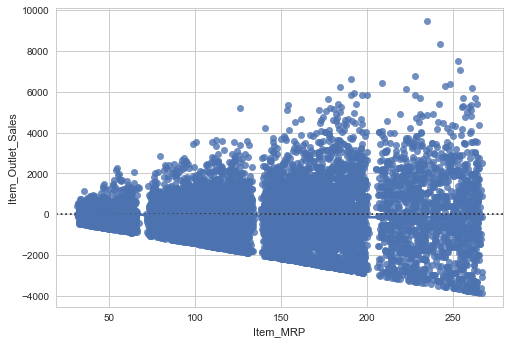

In [18]:
# Seaborn method
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

y = sample_data.iloc[:, -1]
x = sample_data.iloc[:, 4]
x.head()
# Plot the residuals after fitting a linear model
sns.residplot(x, y, lowess=True)
plt.show()

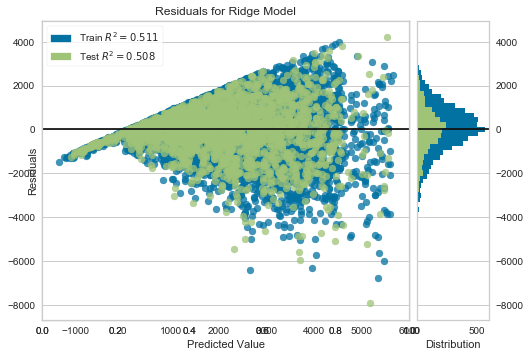

In [25]:
# Yellowbrick method
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import train_test_split

# # Instantiate the linear model and visualizer
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

X_train, X_test, y_train, y_test = train_test_split(sample_data.iloc[:, :-1], sample_data.iloc[:, -1],
 train_size=0.75, test_size=0.25)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()  

* From above Yellowbrick residual plot, the points are not randomly dispersed, which indicates there is nonlinear relationship between the feature set and the label.
* Meanwhile, the funnel shape indicates the non-constant variance (heteroscedasticity) in error terms, and the residuals tend to increase with the response value (Y). What we can try is to transform Y with a concave function (such as log, sqrt), so that the shrinkage of response value could reduce heteroscedasticity.

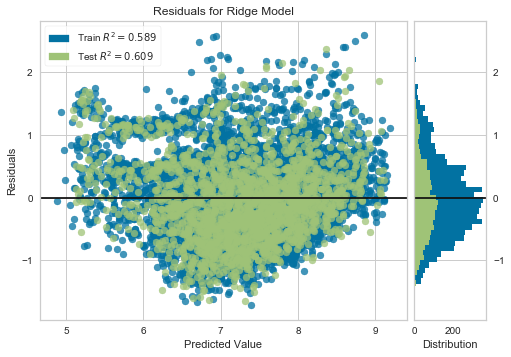

In [37]:
# Transform Y with log() concave function
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

logged_y_train = y_train.apply(math.log)
logged_y_test= y_test.apply(math.log)

visualizer.fit(X_train, logged_y_train)  # Fit the training data to the model
visualizer.score(X_test, logged_y_test)  # Evaluate the model on the test data
visualizer.poof()  

Now we can see the dots are randomly dispersed, which indicates the residuals are having a more constant variance, and there's more linear relationship between the feature set and the transformed response Y.

## Convert Nonlinear Relationship to Linear

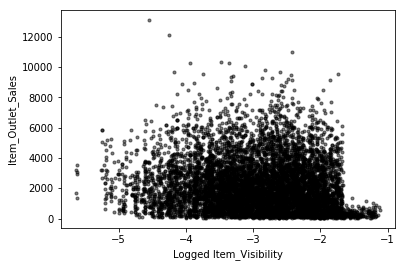

In [16]:
import warnings
warnings.filterwarnings("ignore")

plt.scatter(np.log(sample_data['Item_Visibility']), sample_data['Item_Outlet_Sales'], s=area, c=colors, alpha=0.5)
plt.xlabel('Logged Item_Visibility')
plt.ylabel('Item_Outlet_Sales')
plt.show()

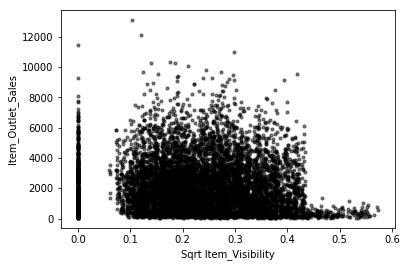

In [17]:
plt.scatter(np.sqrt(sample_data['Item_Visibility']), sample_data['Item_Outlet_Sales'], s=area, c=colors, alpha=0.5)
plt.xlabel('Sqrt Item_Visibility')
plt.ylabel('Item_Outlet_Sales')
plt.show()

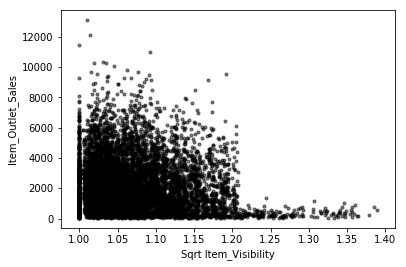

In [18]:
plt.scatter(np.exp(sample_data['Item_Visibility']), sample_data['Item_Outlet_Sales'], s=area, c=colors, alpha=0.5)
plt.xlabel('Sqrt Item_Visibility')
plt.ylabel('Item_Outlet_Sales')
plt.show()

In [51]:
from sklearn.preprocessing import PowerTransformer

normalized_sample_data = pd.DataFrame(PowerTransformer().fit_transform(sample_data))
normalized_sample_data.columns = sample_data.columns
normalized_sample_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,-0.808889,-0.738147,-0.995109,-0.712347,1.623670,1.427394,0.040129,-0.293295,-1.373843,-0.123488,0.985078
1,-1.738575,1.354743,-0.927868,1.504660,-1.595016,-0.548577,-1.616130,-0.293295,1.088324,1.040591,-1.218135
2,1.094638,-0.738147,-0.980257,0.684390,0.081237,1.427394,0.040129,-0.293295,-1.373843,-0.123488,0.220360
3,1.449766,1.354743,-1.332285,-0.215420,0.689968,-1.809119,0.160344,-0.293295,1.088324,-1.915952,-0.835183
4,-0.905013,-0.738147,-1.332285,0.468410,-1.476078,-1.343810,1.223658,-1.925925,1.088324,-0.123488,-0.566616


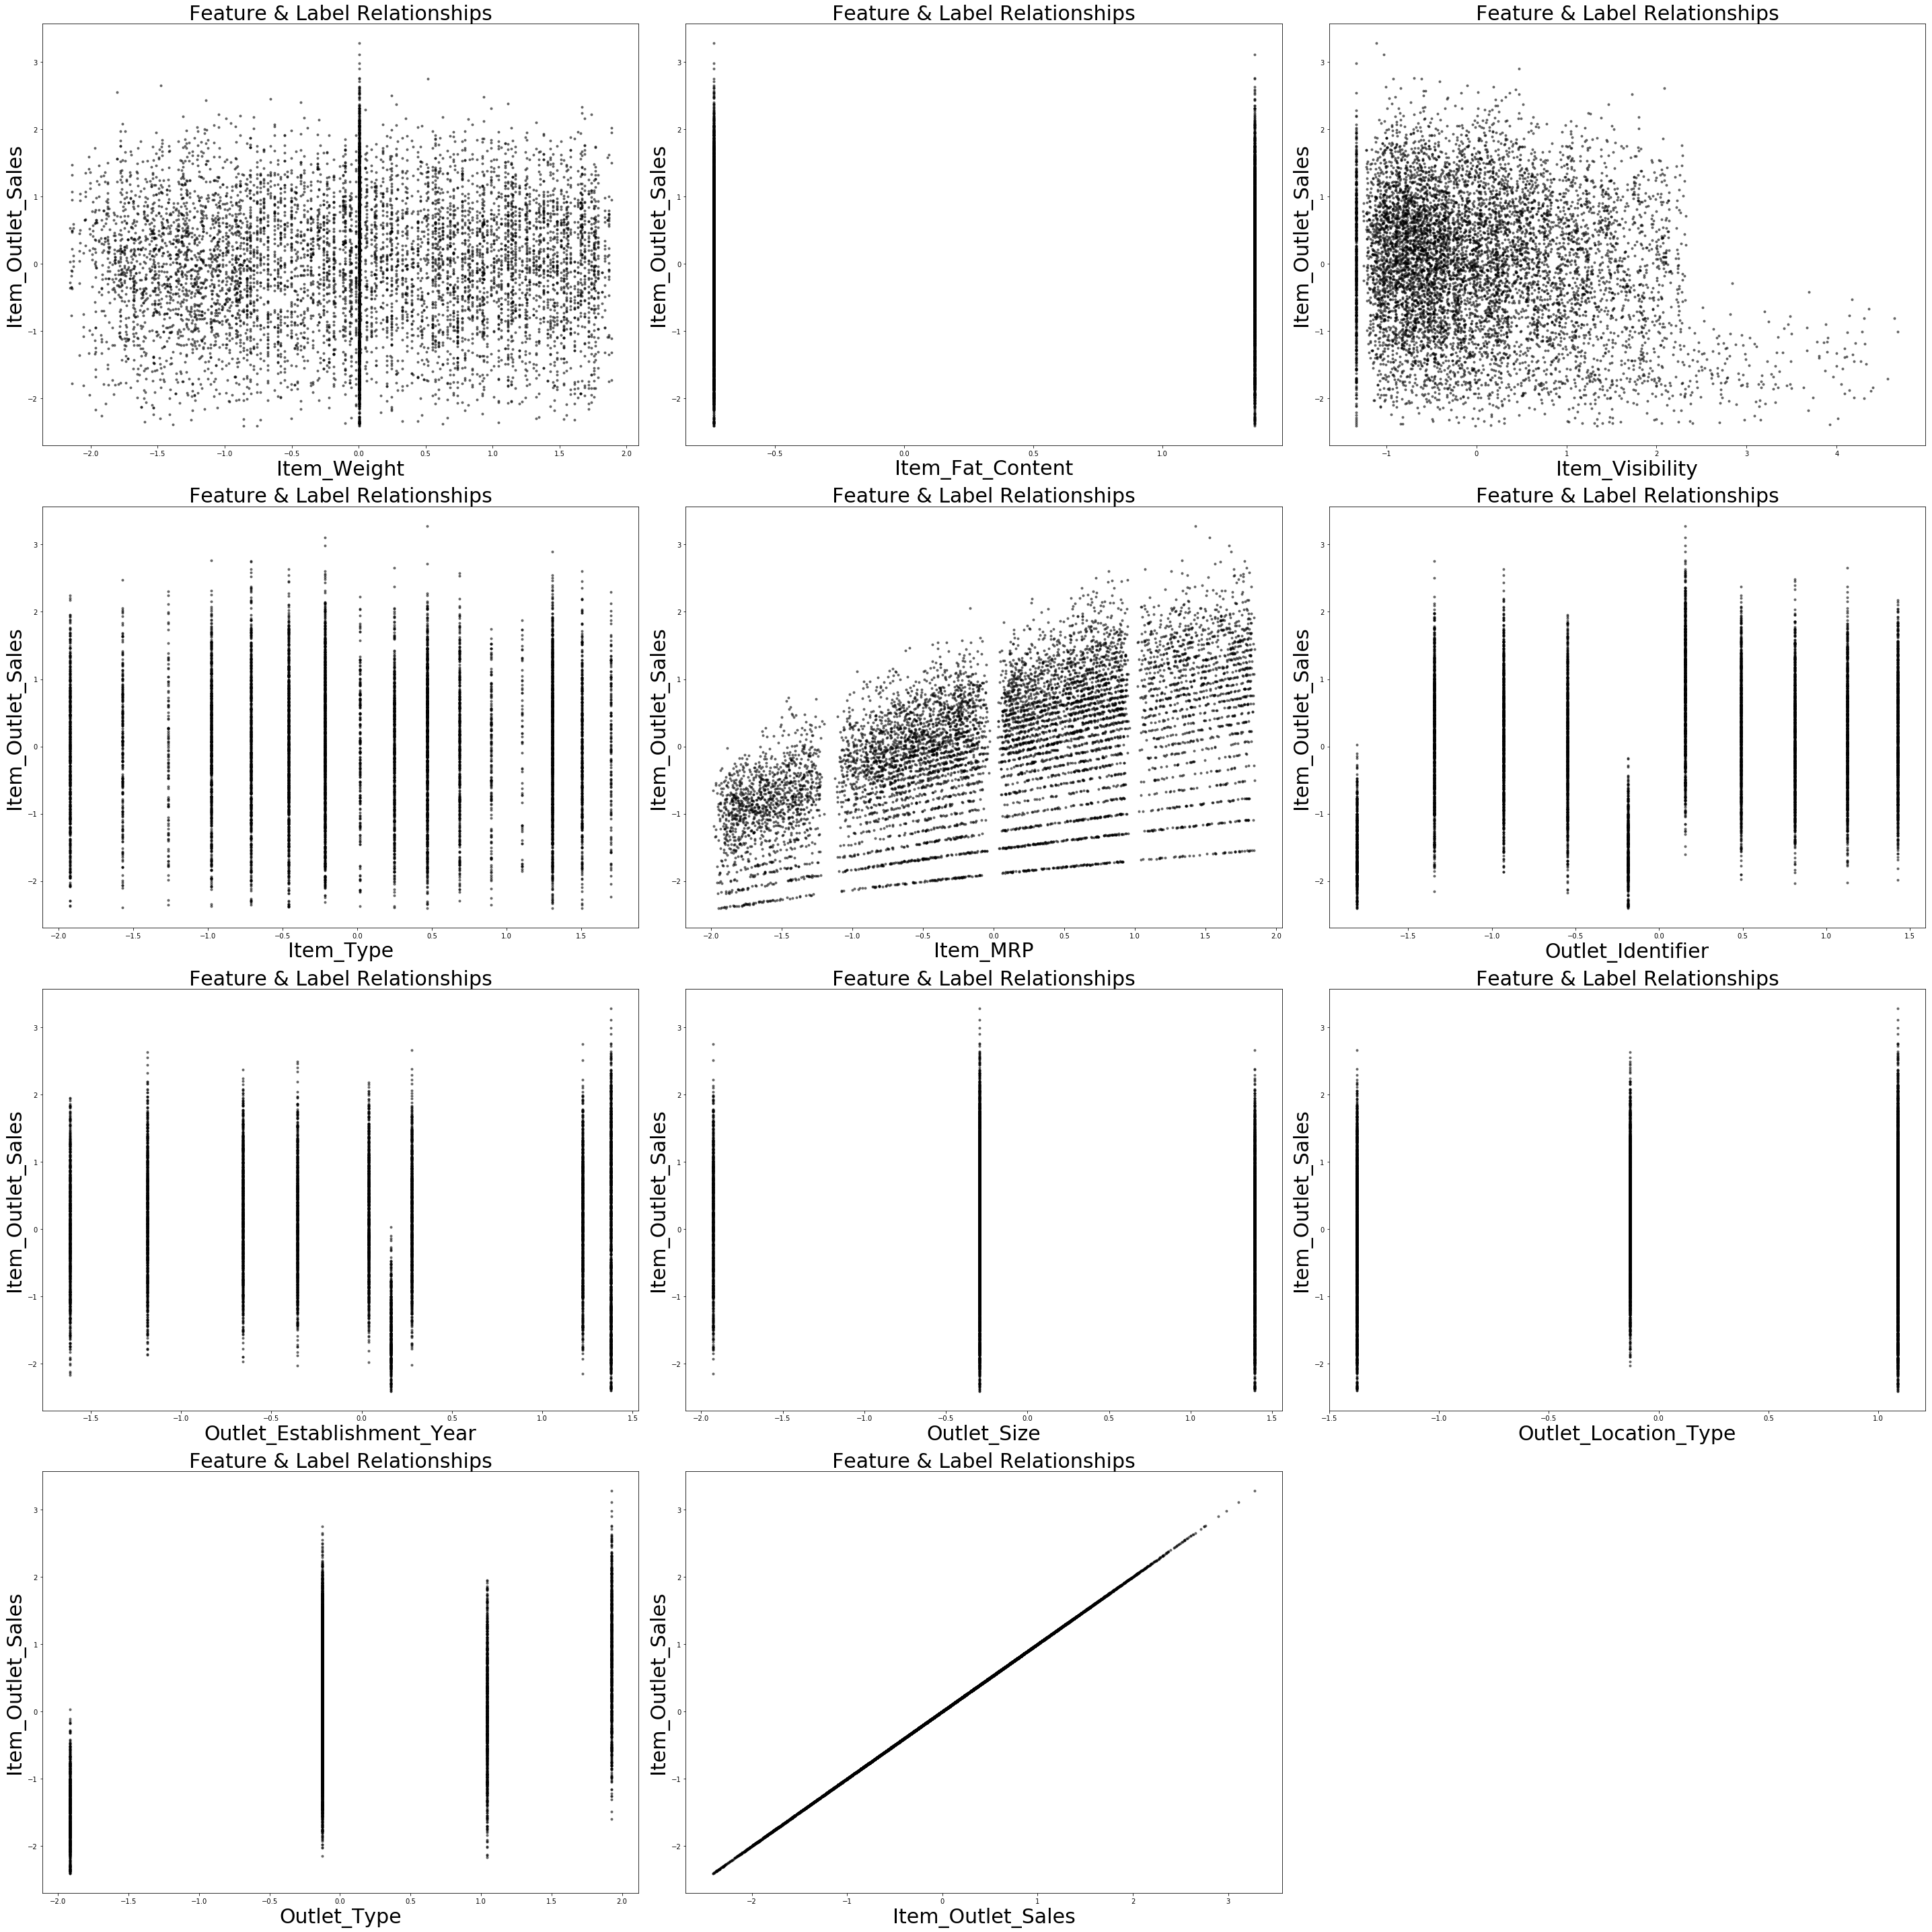

In [52]:
multi_scatter_plot(n_rows, n_cols, normalized_sample_data, y)

List of methods for nonlinear transformation: https://people.revoledu.com/kardi/tutorial/Regression/nonlinear/NonLinearTransformation.htm

## Check Multicollinearity

* Only checking correlation matrix between pair of features may not find all the collinearity issue, because the high correlation could exists between 3+ features, but won't show high correlation between any pair of features. So this is "multicollinearity" issue.
* To find whether there is multicollinearity, we use Variance Inflation Factor (VIF). Large VIF normally indicates there is multicollinearity issue.

In [39]:
X = sample_data.iloc[:, :-1]
X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.30,0,0.016047,4,249.8092,9,18,1,0,1
1,5.92,1,0.019278,14,48.2692,3,8,1,2,2
2,17.50,0,0.016760,10,141.6180,9,18,1,0,1
3,19.20,1,0.000000,6,182.0950,0,19,1,2,0
4,8.93,0,0.000000,9,53.8614,1,30,0,2,1


In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,8.724585,Item_Weight
1,1.554719,Item_Fat_Content
2,2.748424,Item_Visibility
3,3.849309,Item_Type
4,5.725081,Item_MRP
5,10.411339,Outlet_Identifier
6,5.665208,Outlet_Establishment_Year
7,6.484869,Outlet_Size
8,9.257208,Outlet_Location_Type
9,7.537912,Outlet_Type


* There is an implementation of feature selection using VIF: https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class
* Brief but spectacular description of VIF: https://etav.github.io/python/vif_factor_python.html
  * When VIF > 10, it's too high and the feature will be dropped
  * When VIF is between 5 and 10, it indicates that there is multicollineary issue
* There are 2 major methods to deal with features with high VIF
  * Remove the feature
  * Combine features with high VIF together as 1 single feature

## Does Correlation Consider Each Row

* According to the observations below, the correlation methods used in pandas is not simply consider whether there are matched values in both lists, but also consider the positions.

In [7]:
lst1 = [0,0,0,1,1,1]
lst2 = [1,1,1,0,0,0]

df = pd.DataFrame(list(zip(lst1, lst2)), 
               columns =['col1', 'col2']) 
df

,col1,col2
0,0,1
1,0,1
2,0,1
3,1,0
4,1,0
5,1,0


In [11]:
pearson_corr = df['col1'].corr(df['col2'], method='pearson')  # you can also define your own correlation method here
print('pearson correlation', pearson_corr)

kendall_corr = df['col1'].corr(df['col2'], method='kendall')
print('kendall correlation', kendall_corr)

spearman_corr = df['col1'].corr(df['col2'], method='spearman')
print('spearman correlation', spearman_corr)

('pearson correlation', -0.99999999999999978)
('kendall correlation', -1.0)
('spearman correlation', -1.0)


In [12]:
lst1 = [0,0,0,1,1,1]
lst2 = [0,0,0,1,1,0]

df = pd.DataFrame(list(zip(lst1, lst2)), 
               columns =['col1', 'col2']) 
df

,col1,col2
0,0,0
1,0,0
2,0,0
3,1,1
4,1,1
5,1,0


In [13]:
pearson_corr = df['col1'].corr(df['col2'], method='pearson')
print('pearson correlation', pearson_corr)

kendall_corr = df['col1'].corr(df['col2'], method='kendall')
print('kendall correlation', kendall_corr)

spearman_corr = df['col1'].corr(df['col2'], method='spearman')
print('spearman correlation', spearman_corr)

('pearson correlation', 0.70710678118654735)
('kendall correlation', 0.70710678118654746)
('spearman correlation', 0.70710678118654746)


In [14]:
lst1 = [0,0,0,1,1,1]
lst2 = [0,0,0,1,1,1]

df = pd.DataFrame(list(zip(lst1, lst2)), 
               columns =['col1', 'col2']) 
df

,col1,col2
0,0,0
1,0,0
2,0,0
3,1,1
4,1,1
5,1,1


In [15]:
pearson_corr = df['col1'].corr(df['col2'], method='pearson')
print('pearson correlation', pearson_corr)

kendall_corr = df['col1'].corr(df['col2'], method='kendall')
print('kendall correlation', kendall_corr)

spearman_corr = df['col1'].corr(df['col2'], method='spearman')
print('spearman correlation', spearman_corr)

('pearson correlation', 0.99999999999999978)
('kendall correlation', 1.0)
('spearman correlation', 1.0)
